In [1]:
!pip install rouge_score deep-phonemizer

In [169]:
import os

import datasets
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTFeatureExtractor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator


if torch.cuda.is_available():    

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 2 GPU(s) available.
We will use the GPU: Tesla T4


In [3]:
os.environ["WANDB_DISABLED"] = "true"
class config : 
    ENCODER = "google/vit-base-patch16-224"
    DECODER = "gpt2"
    TRAIN_BATCH_SIZE = 8
    VAL_BATCH_SIZE = 8
    SEED = 42
    MAX_LEN = 128
    SUMMARY_LEN = 20
    WEIGHT_DECAY = 0.01
    MEAN = (0.485, 0.456, 0.406)
    STD = (0.229, 0.224, 0.225)
    TRAIN_PCT = 0.95
    NUM_WORKERS = mp.cpu_count()
    EPOCHS = 5
    LABEL_MASK = -100
    TOP_K = 1000
    TOP_P = 0.95

In [4]:
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    return outputs
AutoTokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens

In [6]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.unk_token

/opt/conda/lib/python3.7/site-packages/transformers/models/vit/feature_extraction_vit.py:31: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  FutureWarning,


In [171]:
transforms = transforms.Compose(
    [
        transforms.PILToTensor(),
        transforms.Resize((224,224)), 
        transforms.ToTensor(),
        transforms.Normalize(
            mean=0.5, 
            std=0.5
        )
   ]
)
df=  pd.read_csv("/kaggle/input/flickr8k/captions.txt")
train_df , val_df = train_test_split(df , test_size = 0.2)
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [175]:
class ImgDataset(Dataset):
    def __init__(self, df,root_dir):
        self.df = df
        self.transform = transforms
        self.root_dir = root_dir
        self.tokenizer= tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = 50
    def __len__(self,):
        return len(self.df)
    def __getitem__(self,idx):
        caption = self.df.caption.iloc[idx]
        image = self.df.image.iloc[idx]
        img_path = os.path.join(self.root_dir , image)
        img = Image.open(img_path).convert("RGB")
        
        image_tensor = self.transform(img)
        pixel_values = self.feature_extractor(img, return_tensors="pt").pixel_values
        captions = self.tokenizer(caption,
                                 padding='max_length',
                                 max_length=self.max_length).input_ids
        captions = [caption if caption != self.tokenizer.pad_token_id else -100 for caption in captions]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(captions)}
        return encoding
        
        

# # **Train and validation dataset**

In [176]:
train_dataset = ImgDataset(train_df, root_dir = "/kaggle/input/flickr8k/Images")
val_dataset = ImgDataset(val_df , root_dir = "/kaggle/input/flickr8k/Images")

# # **Model: VisionEncoderDecoder**

In [15]:
# for training
# model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(config.ENCODER, config.DECODER)

# for loading
model = VisionEncoderDecoderModel.from_pretrained('/kaggle/input/vit-gp2model/VIT_large_gpt2')

In [11]:
# model.config.decoder_start_token_id = tokenizer.cls_token_id
# model.config.pad_token_id = tokenizer.pad_token_id
# # make sure vocab size is set correctly
# model.config.vocab_size = model.config.decoder.vocab_size
# # set beam search parameters
# model.config.eos_token_id = tokenizer.sep_token_id
# model.config.decoder_start_token_id = tokenizer.bos_token_id
# model.config.max_length = 128
# model.config.early_stopping = True
# model.config.no_repeat_ngram_size = 3
# model.config.length_penalty = 2.0
# model.config.num_beams = 4

In [12]:
# training_args = Seq2SeqTrainingArguments(
#     output_dir='model-vit-gpt2',
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     do_eval=True,
#     evaluation_strategy="epoch",
#     do_train=True,
#     logging_steps=1024,  
#     warmup_steps=1024,  
#     learning_rate = 5e-3,
#     num_train_epochs = 5,
#     overwrite_output_dir=True,
#     save_total_limit=1,
#     save_steps=2048, 
#     predict_with_generate=True,
# )

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [13]:
# # instantiate trainer
# trainer = Seq2SeqTrainer(
#     tokenizer=feature_extractor,
#     model=model,
#     args=training_args,
#     compute_metrics=compute_metrics,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     data_collator=default_data_collator,
# )

In [ ]:
# trainer.train()

In [ ]:
# trainer.save_model('VIT_large_gpt2')

In [57]:
val_df, test_df = train_test_split(val_df, test_size=50)

,image,caption
163,1042020065_fb3d3ba5ba.jpg,A young boy overlooking a crowd of inflatable ...
244,106490881_5a2dd9b7bd.jpg,The boy is playing on the shore of an ocean .
374,109202756_b97fcdc62c.jpg,Woman n blue jacket sits on daft horse near a ...
555,1119418776_58e4b93eac.jpg,A black and white dog is running through the f...
892,121800200_bef08fae5f.jpg,Many people are climbing the mountain surround...
...,...,...
40133,937559727_ae2613cee5.jpg,A man in fishing overalls in the water .
40153,94232465_a135df2711.jpg,The girl pulls a toddler in a cart while skati...
40221,954987350_a0c608b467.jpg,"A woman in a dark pink tank top , has a bag ac..."
40254,95734036_bef6d1a871.jpg,Man on bicycle trek high in the mountains .


In [59]:
len(test_df)

50

# # **Bleu Scores**

In [60]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from tqdm import tqdm
max_length =35
# Load the predicted and ground truth captions
bleu_scores = []

all_captions = []
all_predictions = []

for key in tqdm(test_df.index): 
#     print(key)
    img = Image.open("/kaggle/input/flickr8k/Images/" + test_df['image'][key]).convert("RGB")
#     print('image loaded')
    predicted_captions = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values)[0])
#     ground_truth_caption = test_df[str(list(encoding_test.keys())[key][:-4])]
#   # print(ground_truth_caption)
#     single_img_captions = []
#     for cap in ground_truth_caption:
#         single_img_captions.append(cap.split()[1:-1])
#     # print(single_img_captions)
#     all_captions.append(single_img_captions)
    predicted_captions = predicted_captions.split()[1:-1]
    print(predicted_captions)
    all_predictions.append(predicted_captions)

  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/generation/utils.py:1292: UserWarning: Using `max_length`'s default (128) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,
  2%|▏         | 1/50 [00:41<34:07, 41.78s/it]

['man', 'and', 'a', 'woman', 'are', 'standing', 'in', 'front', 'of', 'a', 'large', 'group', 'of', 'people.', 'One', 'man', 'is', 'pointing', 'at', 'something', 'while', 'the', 'other', 'man', 'looks', 'at', 'it.', 'The', 'man', 'is', 'holding', 'a', 'camera.', 'The', 'woman', 'is', 'standing', 'next', 'to', 'the', 'man...', 'the', 'man', 'is', 'looking', 'at', 'the', 'camera..', 'and', 'the', 'woman', 'is', 'looking', 'away..', 'at', 'the', "man's", 'hand..', 'a', 'man', 'in', 'a', 'black', 'shirt', 'is', 'standing', 'behind', 'the', 'man', 'in', 'the', 'white', 'shirt..', 'another', 'man', 'is', 'standing', 'in', 'the', 'foreground..', 'two', 'people', 'are', 'standing', 'behind', 'a', 'man.,', 'while', 'a', 'third', 'man', 'stands', 'in', 'the', 'background..', 'in', 'a', 'crowd,', 'a', 'man', 'is', 'throwing']


  4%|▍         | 2/50 [01:24<33:48, 42.27s/it]

['people', 'are', 'walking', 'on', 'the', 'beach.', 'one', 'is', 'pointing', 'at', 'the', "other's", 'face.', 'the', 'two', 'are', 'standing', 'on', 'the', 'sand.', 'the', 'man', 'is', 'pointing.', 'the', 'woman', 'is', 'standing', 'in', 'the', 'distance.', 'the', 'person', 'in', 'the', 'red', 'jacket', 'is', 'pointing', 'to', 'the', 'water.', 'the', 'other', 'is', 'standing', 'on', 'a', 'rocky', 'beach.', 'the', 'people', 'are', 'standing', 'in', 'shallow', 'water.', 'on', 'the', 'shore,', 'the', 'man', 'in', 'the', 'blue', 'jacket', 'is', 'walking.', 'the', 'girl', 'in', 'the', 'pink', 'jacket', 'is', 'standing.', 'the', 'couple', 'in', 'the', 'foreground', 'are', 'standing.', 'walking.', 'in', 'the', 'sand,', 'the', 'woman', 'in', 'the', 'brown', 'jacket', 'is', 'looking', 'at', 'the', 'object', 'in', 'the', 'snow.', 'the', 'object', 'is', 'in', 'the', 'air.']


  6%|▌         | 3/50 [02:06<33:03, 42.21s/it]

['man', 'and', 'a', 'dog', 'are', 'standing', 'in', 'a', 'grassy', 'area', 'with', 'trees', 'in', 'the', 'background.', 'The', 'man', 'is', 'wearing', 'a', 'white', 'shirt', 'and', 'black', 'shorts.', 'The', 'dog', 'is', 'standing', 'in', 'front', 'of', 'the', 'man.', 'The', 'two', 'dogs', 'are', 'wearing', 'white', 'shirts..', 'The', 'woman', 'is', 'wearing', 'black', 'pants..', 'and', 'the', 'man', 'is', 'carrying', 'a', 'backpack.', 'The', 'three', 'dogs', 'are', 'walking.', 'The', 'dogs', 'are', 'running..', 'the', 'woman', 'is', 'standing', 'with', 'a', 'man', 'in', 'a', 'blue', 'jacket.', 'The', 'four', 'dogs', 'are', 'standing..', 'a', 'man', 'is', 'standing', 'next', 'to', 'a', 'black', 'and', 'white', 'dog', 'with', 'a', 'white', 'collar..', 'on', 'a', 'dirt', 'path..', 'with', 'a', 'woman', 'in', 'the']


  8%|▊         | 4/50 [02:48<32:17, 42.12s/it]

['woman', 'sitting', 'at', 'a', 'table', 'in', 'front', 'of', 'a', 'white', 'wall', 'with', 'a', 'drink', 'in', 'her', 'hand.', 'She', 'is', 'looking', 'at', 'a', 'book', 'on', 'the', 'table.', 'She', 'has', 'a', 'black', 'purse', 'in', 'her', 'lap.', 'She', 'looks', 'at', 'her', 'cellphone.', 'She', 'drinks', 'at', 'a', 'restaurant.', 'She', 'sits', 'at', 'a', 'bar.', 'She', 'does', 'not', 'speak.', 'She', 'reads', 'a', 'book.', 'She', 'eats', 'at', 'a', 'place.', 'She', 'smokes', 'a', 'cigarette.', 'She', 'wears', 'a', 'black', 'tank', 'top.', 'She', 'leans', 'against', 'a', 'table', 'at', 'a', 'cafe.', 'She', 'appears', 'to', 'be', 'in', 'a', 'room', 'with', 'a', 'black', 'shirt.', 'She', 'stares', 'at', 'a', 'picture', 'on', 'a', 'laptop.', 'She', 'smiles', 'at', 'a', 'drink.', 'She', 'stands', 'at', 'a', 'desk.']


 10%|█         | 5/50 [03:31<31:43, 42.29s/it]

['black', 'dog', 'is', 'running', 'through', 'the', 'water', 'with', 'a', 'stick', 'in', 'its', 'mouth...', 'a', 'lake', 'in', 'the', 'background..', 'another', 'dog', 'is', 'in', 'the', 'foreground..', 'and', 'a', 'third', 'dog', 'is', 'jumping', 'out', 'of', 'the', 'water..', 'in', 'a', 'lake..', 'the', 'water', 'is', 'clear.', 'the', 'sky', 'is', 'blue.', 'a', 'ball', 'is', 'flying', 'through', 'the', 'air.', 'a', 'body', 'of', 'water.', 'the', 'dog', 'is', 'swimming.', 'the', 'ball', 'is', 'coming', 'out', 'of', 'its', 'body.', 'in', 'the', 'water,', 'the', 'dog', 'catches', 'the', 'stick.', 'the', 'lake', 'is', 'blue', 'and', 'the', 'dog', 'has', 'caught', 'the', 'ball.', 'the', 'two', 'dogs', 'are', 'running', 'towards', 'the', 'shore.', 'the', 'object', 'is', 'a', 'ball', 'in', 'the', 'lake.']


 12%|█▏        | 6/50 [04:13<31:03, 42.35s/it]

['girl', 'in', 'a', 'black', 'swimsuit', 'is', 'jumping', 'into', 'a', 'swimming', 'pool...', 'and', 'another', 'girl', 'is', 'in', 'the', 'back', 'of', 'the', 'swimming', 'pool', 'with', 'a', 'ball', 'in', 'her', 'hand..', 'the', 'girl', 'in', 'the', 'pink', 'swimsuit', 'has', 'jumped', 'into', 'the', 'air..', 'another', 'girl', 'in', 'pink', 'swim', 'shorts..', 'in', 'the', 'background.', 'the', 'boy', 'in', 'the', 'white', 'swimsuit', 'jumps', 'into', 'the', 'pool.', 'the', 'kid', 'in', 'the', 'blue', 'swimsuit', 'does', 'a', 'handstand.', 'the', 'child', 'in', 'the', 'yellow', 'swimsuit.', 'the', 'baby', 'in', 'the', 'brown', 'swimsuit', 'gets', 'splashed.', 'the', 'little', 'girl', 'in', 'blue', 'swim', 'shorts', 'is', 'in', 'a', 'pool.', 'and', 'the', 'boy', 'is', 'diving', 'into', 'the', 'water..']


 14%|█▍        | 7/50 [04:55<30:17, 42.26s/it]

['little', 'girls', 'are', 'hugging', 'each', 'other.', 'One', 'has', 'a', 'blue', 'ribbon', 'on', 'her', 'arm.', 'and', 'the', 'other', 'has', 'a', 'red', 'ribbon.', 'and', 'one', 'has', 'a', 'pink', 'ribbon..', 'and', 'both', 'have', 'blue', 'hearts', 'on', 'her', 'chest.', 'the', 'girl', 'in', 'the', 'blue', 'ribbon', 'is', 'holding', 'a', 'blue', 'toy.', 'the', 'boy', 'in', 'the', 'pink', 'one', 'is', 'holding', 'the', 'blue', 'toy', 'is', 'holding.', 'the', 'red', 'toy', 'is', 'playing', 'with.', 'the', 'pink', 'girl.', 'the', 'blue', 'girl', 'is', "holding's", "hand.'s", 'ear.', 'the', 'other', 'girl', 'is', 'sitting', 'next', 'to', 'her.', 'the', 'blonde', 'girl', 'is', 'writing', 'on', 'the', 'red', "girl's", 'back.', 'the', 'brunette', 'girl', 'is', 'reading', 'the', 'blue', 'book.', 'the', 'blond']


 16%|█▌        | 8/50 [05:37<29:26, 42.07s/it]

['group', 'of', 'children', 'are', 'standing', 'in', 'front', 'of', 'a', 'church.', 'One', 'boy', 'is', 'holding', 'a', 'book', 'while', 'another', 'boy', 'is', 'standing', 'behind', 'him.', 'The', 'boy', 'in', 'the', 'red', 'shirt', 'is', 'holding', 'the', 'book.', 'The', 'girl', 'in', 'the', 'white', 'shirt', 'is', 'standing', 'next', 'to', 'the', 'girl', 'in', 'a', 'blue', 'shirt.', 'The', 'girls', 'in', 'the', 'blue', 'shirts', 'are', 'all', 'singing.', 'The', 'boys', 'in', 'the', 'church', 'are', 'all', 'standing', 'in', 'the', 'background..', 'One', 'girl', 'is', 'standing', 'with', 'a', 'group', 'of', 'other', 'children.', 'The', 'group', 'is', 'all', 'singing', 'in', 'unison.', 'The', 'children', 'are', 'all', 'looking', 'in', 'the', 'direction', 'of', 'the', 'church.', 'They', 'are', 'all', 'holding', 'American', 'flags.', 'The', 'church', 'is', 'filled', 'with']


 18%|█▊        | 9/50 [06:19<28:41, 41.98s/it]

['little', 'boy', 'is', 'playing', 'with', 'a', 'red', 'ball.', '"', 'he', 'says.', '"', 'Where', 'are', 'you?', '"', 'he', 'points.', '"', 'The', 'yellow', 'ball', 'is', 'in', 'his', 'hand.', '"', 'and', 'the', 'red', 'one', 'is', 'on', 'his', 'head.', '".', '"', 'where', 'is', 'the', 'yellow', 'ball?', '"', '"', 'he', 'is', 'holding.', '"', 'the', 'yellow', 'one.', '"', '"', 'Where', 'is', 'the', 'blue', 'one?', '"\'s', 'hand?', '".', 'The', 'little', 'boy', 'has', 'his', 'hand', 'in', 'his', 'pocket.', '",', 'and', 'the', 'boy', 'is', 'holding', 'the', 'yellow', 'and', 'blue', "one's.", '"', 'blue', 'one..', '"', "hand.'s", 'up.', '"\'he', 'has.', '"', 'a', 'yellow', 'ball', 'in', 'his', 'right']


 20%|██        | 10/50 [07:00<27:54, 41.87s/it]

['children', 'are', 'standing', 'on', 'a', 'tree', 'trunk.', 'one', 'is', 'holding', 'a', 'rope.', 'the', 'other', 'is', 'leaning', 'on', 'a', 'railing.', 'the', 'third', 'is', 'looking', 'at', 'the', 'camera.', 'the', 'young', 'man', 'is', 'standing', 'on', 'the', "other's", 'shoulders.', 'standing', 'on', "both's", 'sides..', 'the', 'younger', 'man', 'is', 'leaning', 'against', 'the', 'older', "man's", 'shoulder..', 'standing..', 'on', 'the', 'railing...', 'at', 'the', 'edge', 'of', 'the', 'ground..', 'and', 'one', 'is', 'looking', 'up..,', 'the', 'young', 'boy', 'is', 'standing.', "on..'s", 'feet..', 'in', 'the', 'middle', 'of', 'the', 'trees.', 'and', 'the', 'younger', 'boy', 'is', 'leaning..', 'against', 'the', 'taller']


 22%|██▏       | 11/50 [07:43<27:22, 42.13s/it]

['man', 'in', 'a', 'black', 't-shirt', 'and', 'black', 'shorts', 'is', 'laying', 'on', 'the', 'ground', 'with', 'his', 'hands', 'on', 'his', 'hips...', 'with', 'his', 'feet', 'on', 'the', 'floor..', 'in', 'front', 'of', 'a', 'black', 'and', 'white', 'building..', 'on', 'a', 'concrete', 'floor.', 'with', 'a', 'black', 'background..', 'a', 'man', 'in', 'shorts', 'and', 'a', 'white', 'bag..', 'sitting', 'on', 'a', 'wooden', 'bench.', 'in', 'the', 'background.', 'on', 'the', 'opposite', 'side..', 'holding', 'a', 'black', 'bag.', 'in', 'his', 'right', 'hand..', 'leaning', 'against', 'a', 'wooden', 'railing..', 'looking', 'down..', 'his', 'back..', 'and', 'looking', 'up.', 'on', 'his', 'cellphone..', 'lying', 'on', 'the', 'concrete', 'ground..', 'wearing', 'a', 'black', 'shirt']


 24%|██▍       | 12/50 [08:24<26:32, 41.90s/it]

['black', 'dogs', 'are', 'running', 'in', 'the', 'snow.', 'One', 'has', 'a', 'ball', 'in', 'its', 'mouth.', 'The', 'other', 'has', 'a', 'red', 'ball.', 'The', 'black', 'dog', 'is', 'chasing', 'the', 'black', 'dog.', 'The', 'two', 'dogs', 'are', 'playing', 'in', 'the', 'deep', 'snow.', 'The', 'dog', 'in', 'the', 'red', 'collar', 'is', 'jumping.', 'The', 'dogs', 'in', 'the', 'black', 'collar', 'are', 'running', 'away.', 'The', 'red', 'dog', 'is', 'running.', 'The', 'brown', 'dog', 'is', 'catching', 'the', 'ball.The', 'black', 'dog', 'has', 'something', 'in', 'his', 'mouth.The', 'two', 'black', 'dogs', 'have', 'something', 'in', 'their', 'mouths.The', 'brown', 'dog', 'in', 'front', 'of', 'the', 'black', 'dogs', 'is', 'running', 'through', 'the', 'black', 'snow.The', 'dogs', 'are', 'chasing', 'the', 'red', 'dog.The', 'red', 'dog', 'runs', 'in', 'the']


 26%|██▌       | 13/50 [09:06<25:49, 41.87s/it]

['woman', 'is', 'petting', 'a', 'dog', 'on', 'a', 'stone', 'path.', 'She', 'is', 'standing', 'next', 'to', 'a', 'large', 'building.', 'She', 'has', 'a', 'large', 'stick', 'in', 'her', 'mouth.', 'The', 'dog', 'is', 'jumping', 'up', 'at', 'her.', 'She', 'looks', 'at', 'the', 'camera..', 'The', 'woman', 'in', 'the', 'brown', 'coat', 'is', 'standing', 'beside', 'the', 'dog.', 'She', 'stands', 'next', 'to', 'the', "water's", 'edge.', 'The', 'brown', 'dog', 'is', 'drinking', 'from', 'a', 'large', 'bottle.', 'The', 'person', 'in', 'the', 'black', 'coat', 'is', 'sitting', 'on', 'the', 'ground.', 'The', 'large', 'dog', 'is', 'looking', 'at', 'the', 'brown', 'dog.The', 'brown', 'dog', 'has', 'a', 'stick', 'in', 'its', 'mouth.The', 'woman', 'in', 'a', 'brown', 'coat', 'and', 'the', 'large', 'dog', 'are', 'looking', 'at', 'each', 'other.The']


 28%|██▊       | 14/50 [09:42<24:00, 40.01s/it]

['little', 'boy', 'jumps', 'off', 'of', 'a', 'red', 'slide...', 'in', 'the', 'backyard..', 'with', 'a', 'blue', 'and', 'yellow', 'house', 'in', 'the', 'background..', 'a', 'boy', 'in', 'a', 'blue', 'shirt', 'and', 'blue', 'shorts', 'is', 'jumping', 'off', 'of', 'the', 'green', 'slide', 'in', 'the', 'park..', 'at', 'the', 'top', 'of', 'a', 'blue', 'slide.', 'at', 'a', 'playground..', 'and', 'a', 'little', 'boy', 'in', 'an', 'orange', 'shirt', 'and', 'shorts', 'is', 'in', 'the', 'middle', 'of', 'a', 'green', 'and', 'yellow', 'slide.', 'in', 'a', 'grassy', 'area..', 'on', 'a', 'green,', 'green,', 'grassy,', 'yard..', 'playground-like']


 30%|███       | 15/50 [10:24<23:41, 40.62s/it]

['person', 'is', 'doing', 'a', 'trick', 'on', 'a', 'bike', 'in', 'the', 'woods...', 'with', 'a', 'tree', 'in', 'the', 'background.', '"', 'it', 'looks', 'like', 'a', 'mountain.', '"', 'he', 'is', 'jumping.', '"..', '"', 'a', 'person', 'is', 'in', 'the', 'air.', '"', 'the', 'air', 'on', 'his', 'bike.', '"', 'is', 'in', 'midair.', '"', 'doing', 'a', 'stunt.', '"', 'in', 'the', 'middle', 'of', 'the', 'woods.".', '"', 'with', 'a', 'mountain', 'in', 'the', 'foreground.', '"', 'on', 'his', 'bicycle.', '"', 'jumping', 'over', 'a', 'fallen', 'tree.', '",', 'in', 'the', 'forest.', '"', 'his', 'bike', 'is', 'airborne.', '"', '".', '"', 'at', 'the', 'top', 'of', 'a', 'hill.', '"', 'making', 'a', 'jump.', '"', 'as', 'he', 'is', 'performing', 'a']


 32%|███▏      | 16/50 [11:05<23:04, 40.71s/it]

['man', 'in', 'a', 'red', 'shirt', 'is', 'jumping', 'in', 'front', 'of', 'a', 'building...', 'and', 'another', 'man', 'is', 'standing', 'in', 'the', 'background.', 'The', 'man', 'in', 'the', 'red', 'shirt', 'has', 'his', 'arms', 'in', 'the', 'air..', 'The', 'two', 'men', 'are', 'in', 'the', 'foreground..', '"!', '"!.', '".', '"?', '"!!', '".', 'The', 'boy', 'in', 'the', 'blue', 'shirt', 'is', 'in', 'the', 'middle', 'of', 'the', 'two', 'men..', 'Both', 'men', 'are', 'wearing', 'black', 'shirts..', 'One', 'man', 'is', 'doing', 'a', 'back', 'flip..', 'the', 'other', 'man', 'is', 'jumping.', 'The', 'guy', 'in', 'the', 'green', 'shirt', 'is', 'doing', 'backflips.The', 'boy', 'in', 'red', 'shorts', 'is', 'doing', 'an', 'aerial', 'leap.The', 'man']


 34%|███▍      | 17/50 [11:46<22:28, 40.86s/it]

['group', 'of', 'people', 'are', 'playing', 'instruments.', 'One', 'is', 'holding', 'a', 'guitar', 'and', 'the', 'other', 'is', 'playing', 'the', 'bagpipe..', 'one', 'is', 'singing...', 'the', 'drummer', 'is', 'standing..', 'and', 'the', 'third', 'is', 'playing', 'a', 'bagpipes..', 'each', 'has', 'a', 'white', 'bag..', 'a', 'black', 'bag.', 'a', 'red', 'bag.', 'and', 'a', 'green', 'bag.', 'the', 'one', 'is', 'holding', 'an', 'orange', 'bag.', 'all', 'are', 'dressed', 'in', 'black..', 'two', 'are', 'playing', 'drums..,', 'one', 'is', 'standing', 'and', 'one', 'is', 'sitting..', 'they', 'are', 'playing..', 'there', 'is', 'one', 'black', 'and', 'one', 'white..', 'three', 'are', 'playing', 'together.', 'the', 'black', 'one', 'is', 'playing.', 'the', 'white', 'one']


 36%|███▌      | 18/50 [12:27<21:48, 40.89s/it]

['person', 'is', 'tentatively', 'sleeping', 'in', 'front', 'of', 'a', 'tent', 'in', 'the', 'snow.', 'The', 'tent', 'is', 'covered', 'in', 'snow.', 'A', 'tent', 'is', 'attached', 'to', 'a', 'yellow', 'tent.', 'The', 'person', 'is', 'wearing', 'a', 'yellow', 'jacket.', 'A', 'person', 'is', 'sitting', 'on', 'the', 'ground', 'with', 'their', 'back', 'to', 'the', 'camera.', 'They', 'are', 'tentatively', 'looking', 'at', 'the', 'sun.', 'The', 'sun', 'is', 'shining', 'through', 'their', 'tent..', 'They', 'have', 'a', 'tent', 'wrapped', 'around', 'them.', 'They', 'can', 'see', 'through', 'the', 'tent.', 'A', 'man', 'is', 'sitting', 'in', 'the', 'tent', 'with', 'their', 'arms', 'out.', 'The', 'tents', 'are', 'covered', 'with', 'snow..', 'The', 'man', 'is', 'wearing', 'an', 'orange', 'jacket.', 'The', 'woman', 'is', 'wearing', 'protective', 'gear.', 'The', 'campsite', 'is', 'located']


 38%|███▊      | 19/50 [13:09<21:19, 41.26s/it]

['greyhounds', 'are', 'racing', 'around', 'a', 'track.', 'One', 'has', 'a', 'muzzle', 'and', 'the', 'other', 'is', 'wearing', 'a', 'black', 'jacket...', 'with', 'a', 'muzzle..', 'on', 'a', 'greyhound..', 'race..', 'dog.', 'number', 'six.', 'running..', 'number', 'seven.', 'on', 'the', 'dog..', 'run..', 'dogs.', 'number', 'eight.', 'are', 'running.', 'number', 'ten..', 'in', 'the', 'dog', 'race.', 'number', 'eleven..', 'are', 'in', 'the', 'race.', 'and', 'number', 'eight', 'is', 'in', 'the', 'lead..', 'the', 'dogs', 'are', 'numbered..', 'six.', 'are..', 'numbered.', 'in..', 'muzzles..', '#', '8', 'dogs', 'are.', 'numbered', 'in.', '#', '11', 'dogs', 'are']


 40%|████      | 20/50 [13:50<20:36, 41.23s/it]

['black', 'and', 'white', 'dog', 'is', 'running', 'through', 'the', 'water...', 'with', 'a', 'stick', 'in', 'its', 'mouth..', 'in', 'front', 'of', 'a', 'lake..', 'the', 'water', 'is', 'blue', 'and', 'green..', 'The', 'black', 'dog', 'is', 'jumping..', 'into', 'the', 'lake.', 'The', 'water.', 'the', 'black', 'dog', 'has', 'a', 'ball', 'in', 'his', 'mouth.', 'The', 'dog', 'is', 'splashing..', 'it', 'is', 'running..', 'out', 'of', 'the', 'water,', 'into', 'the', "water's", 'edge..', 'a', 'black', 'dog', 'in', 'the', 'water', 'has', 'a', 'stick.', 'the', 'dog', 'is', 'swimming..', 'at', 'the', 'edge', 'of', 'the', 'lake,', 'in', 'the', "lake's", 'water,', 'the', 'dog', 'jumps..', 'and', 'the', 'black', 'and', 'brown', 'dog']


 42%|████▏     | 21/50 [14:31<19:53, 41.16s/it]

['little', 'girl', 'in', 'a', 'pink', 'shirt', 'is', 'pointing', 'at', 'the', 'sky...', 'at', 'the', 'beach..', 'and', 'at', 'the', 'ocean..', 'as', 'another', 'girl', 'stands', 'on', 'the', "shore..'s", 'feet..', 'the', 'girl', 'in', 'the', 'foreground', 'is', 'looking', 'at', 'the', 'camera..,', 'the', 'girl', 'on', 'the', 'beach', 'is', 'looking', 'away..', 'in', 'the', 'distance..', 'a', 'little', 'boy', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'the', 'sand', 'at', 'the', 'top', 'of', 'the', "ocean's", 'edge..', 'on', 'a', 'beach,', 'the', 'boy', 'in', 'the', 'background', 'is', 'pointing.', 'at', 'something..', 'to', 'the', 'right..', 'another', 'little', 'girl', 'is', 'standing', 'at', 'the', 'edge', 'of', 'the', 'water..', 'with']


 44%|████▍     | 22/50 [15:13<19:18, 41.37s/it]

['man', 'and', 'a', 'woman', 'are', 'looking', 'at', 'each', 'other', 'in', 'front', 'of', 'a', 'bus.', 'The', 'man', 'is', 'wearing', 'sunglasses.', 'The', 'woman', 'is', 'wearing', 'a', 'black', 'hat.', 'The', 'two', 'women', 'are', 'wearing', 'black', 'sunglasses.', '"', 'I', 'love', 'you,', 'man.', '"', 'the', 'man', 'and', 'woman', 'are', 'both', 'wearing', 'black', 'hats.', '"', 'man,', 'woman,', 'and', 'boy.', '"', 'smile', 'for', 'the', 'camera.', '"', 'look', 'at', 'the', 'camera,', 'man', 'in', 'sunglasses,', 'woman', 'in', 'black', 'hat,', 'and', 'man', 'in', 'white', 'hat.', '"', 'oh,', 'man,', 'look', 'up.', '"', 'are', 'looking', 'down.', '"', 'and', 'man,', 'smile.', '".', '",', 'the', 'man', 'in', 'the', 'black', 'hat', 'and', 'woman', 'in', 'the', 'white', 'hat']


 46%|████▌     | 23/50 [15:54<18:34, 41.28s/it]

['little', 'boy', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'in', 'front', 'of', 'a', 'store', 'window.', 'A', 'man', 'in', 'a', 'white', 'shirt', 'stands', 'behind', 'him...', 'a', 'woman', 'in', 'a', 'pink', 'shirt..', 'and', 'a', 'boy', 'in', 'blue', 'shorts..', 'all', 'in', 'the', 'same', 'place..', 'the', 'same', 'window..', 'standing..', 'outside..', 'in', 'front..', 'of', 'a', 'brick', 'building..', 'holding', 'up', 'a', 'sign..', 'while', 'another', 'boy', 'stands..', 'behind..', 'another', 'boy..', 'stands.', 'and', 'looks..', 'at', 'the', 'camera.', 'while', 'a', 'third', 'boy', 'stands', 'in', 'the', 'background..', 'his', 'hand', 'is', 'on', 'his', 'head..', 'as', 'a', 'boy', 'stands', 'behind.', 'a']


 48%|████▊     | 24/50 [16:35<17:53, 41.27s/it]

['brown', 'horse', 'is', 'galloping', 'through', 'the', 'grass...', 'a', 'black', 'and', 'white', 'horse..', 'the', 'rider', 'is', 'wearing', 'a', 'white', 'helmet..', '"..', 'The', 'horse', 'is', 'in', 'front', 'of', 'the', 'fence..', 'and', 'the', "rider's", 'feet', 'are', 'in', 'the', 'air..', '"..', '"', "'.", '"', 'The', "horse's", 'head', 'is', 'in', 'the', 'foreground..\'".', '"', '".', "'.", 'The', 'rider', 'is', 'riding', 'in', 'the', 'background..."', "'.", '".', "'.", "'The", 'horse', 'is', 'running', 'in', 'the', 'field..', '"\'.', '"The', 'horse', 'has', 'its', 'mouth', 'wide', 'open.\'"..\'\'The', 'rider', 'is', 'looking', 'at', 'the', 'horse']


 50%|█████     | 25/50 [16:52<14:10, 34.01s/it]

['man', 'and', 'a', 'woman', 'are', 'sitting', 'on', 'a', 'bench', 'near', 'a', 'park', 'bench.', 'The', 'man', 'is', 'wearing', 'a', 'red', 'sweater', 'and', 'a', 'white', 'hat.', 'The', 'woman', 'is', 'wearing', 'sunglasses.', 'The', 'elderly', 'woman', 'is', 'sitting', 'on', 'the', 'bench.', 'A', 'man', 'is', 'eating', 'ice']


 52%|█████▏    | 26/50 [17:34<14:28, 36.18s/it]

['man', 'on', 'a', 'four-wheeler', 'is', 'riding', 'on', 'a', 'sandy', 'hill.', 'The', 'man', 'is', 'wearing', 'a', 'helmet...', 'and', 'the', 'helmet', 'is', 'on..', 'black..', 'sandals..', '"', 'sandals', 'are', 'flying.', '"', 'on', 'the', 'ground.', '"', 'in', 'the', 'air.', '".', '"', 'the', 'sky.', '"', 'are', 'you', 'can', 'see', 'it.', '"!', '".', 'the', 'clouds', 'are', 'blowing', 'in', 'the', 'background.', '"', 'and', 'the', 'man', 'is', 'on', 'a', 'black', 'and', 'white.', '"', 'helmet.', '"', 'is', 'in', 'the', 'middle', 'of', 'a', 'jump.', '"', 'hi-hikers', '"', 'are', 'riding', 'on', 'the', 'side', 'of', 'the', 'road.', '"', 'jacked', '"', 'are', 'on', 'a']


 54%|█████▍    | 27/50 [18:15<14:29, 37.81s/it]

['group', 'of', 'people', 'are', 'riding', 'a', 'red', 'and', 'white', 'bike', 'in', 'a', 'parade.', 'One', 'person', 'is', 'holding', 'a', 'red', 'bike', 'while', 'the', 'other', 'person', 'is', 'riding', 'a', 'yellow', 'bike.', 'The', 'red', 'bike', 'is', 'in', 'the', 'middle', 'of', 'the', 'parade.', 'The', 'two', 'people', 'are', 'holding', 'red', 'bikes.', 'The', 'man', 'in', 'the', 'yellow', 'bike', 'is', 'raising', 'his', 'arms.', 'The', 'woman', 'in', 'the', 'orange', 'bike', 'is', 'also', 'raising', 'her', 'arms.The', 'man', 'with', 'the', 'red', 'bike', 'has', 'a', 'crowd', 'behind', 'him.The', 'two', 'people', 'with', 'red', 'bikes', 'are', 'standing', 'in', 'front', 'of', 'a', 'red', 'bicycle.The', 'red', 'bike', 'and', 'the', 'person', 'with', 'the', 'green', 'bike', 'are', 'in', 'the', 'foreground.The', 'woman', 'with', 'the', 'pink', 'bike', 'is', 'riding', 'the', 'red']


 56%|█████▌    | 28/50 [18:57<14:19, 39.06s/it]

['little', 'girl', 'in', 'a', 'pink', 'dress', 'is', 'standing', 'on', 'a', 'tree', 'stump', 'with', 'a', 'pink', 'umbrella...', 'well..', 'a', 'little', 'girl..', 'in', 'a', 'dress..', 'and', 'a', 'little', 'boy', 'in', 'a', 'blue', 'dress.,', 'standing', 'on', 'the', 'ground..', 'laughing..', 'standing.', 'in', 'the', 'middle', 'of', 'a', 'pile', 'of', 'leaves..', 'smiling..', 'with', 'a', 'girl', 'in', 'pink..', 'on', 'a', 'pink', 'skirt..', 'walking..', 'down', 'a', 'tree..', 'the', 'girl', 'in', 'the', 'pink', 'dress,', 'wearing', 'a', 'purple', 'dress,', 'is', 'holding', 'a', 'pink', "ribbon..'s", 'hand..', 'her', "sister's..", 'hand.', 'is', 'standing', 'in', 'the']


 58%|█████▊    | 29/50 [19:09<10:45, 30.73s/it]

['black', 'poodle', 'with', 'a', 'red', 'toy', 'in', 'its', 'mouth...', 'a', 'brown', 'poodle', 'in', 'the', 'background..', 'and', 'a', 'black', 'dog', 'in', 'front', 'of', 'a']


 60%|██████    | 30/50 [19:50<11:17, 33.89s/it]

['young', 'boy', 'jumps', 'off', 'of', 'a', 'jump...', 'in', 'a', 'park..', 'his', 'arms', 'in', 'the', 'air..', 'and', 'his', 'feet', 'on', 'the', 'ground..', 'with', 'onlookers', 'in', 'the', 'background..', 'as', 'he', 'does', 'a', 'flip..', 'a', 'boy', 'jumps', 'in', 'the', 'foreground..', 'the', 'boy', 'jumps.', 'and', 'the', 'boy', 'looks', 'up..', 'at', 'the', 'camera..', 'no', 'one', 'jumps..,', 'the', 'boy', 'does', 'a', 'back', 'flip.', 'a', 'third', 'boy', 'jumps', 'and', 'the', 'third', 'boy', 'looks', 'down.', 'a', 'fence..', 'on', 'the', 'other', 'hand..', 'jumps.', 'in', 'the', 'other', 'direction..', 'another', 'boy', 'jumps', 'on', 'the', 'fence.', 'and', 'another', 'boy', 'watches..']


 62%|██████▏   | 31/50 [20:32<11:30, 36.33s/it]

['man', 'walking', 'down', 'a', 'city', 'street', 'with', 'his', 'hand', 'on', 'his', 'shoulder...', 'a', 'man', 'in', 'a', 'black', 'coat', 'and', 'hat..', 'and', 'a', 'woman', 'in', 'a', 'white', 'coat', 'and', 'black', 'pants..', 'standing', 'on', 'a', 'sidewalk..', 'in', 'the', 'middle', 'of', 'a', 'busy', 'street..', 'looking', 'down..', 'on', 'a', 'city', 'sidewalk.', 'in', 'a', 'city..', 'light', 'rain..', 'the', 'street', 'is', 'dark..,', 'the', 'city', 'is', 'cloudy.,', 'and', 'there', 'is', 'a', 'man', 'walking', 'on', 'the', 'side', 'of', 'the', 'road..', 'with', 'a', 'light', 'coat', 'and', 'scarf..', 'walking', 'down', 'the', 'sidewalk.', 'a', 'street.,', 'a', 'man', 'wearing', 'a', 'black', 'hat.', 'and', 'black']


 64%|██████▍   | 32/50 [21:07<10:48, 36.03s/it]

['woman', 'in', 'a', 'red', 'jacket', 'is', 'looking', 'at', 'a', 'man', 'in', 'a', 'blue', 'jacket.', 'The', 'man', 'is', 'looking', 'away.', 'The', 'woman', 'in', 'the', 'blue', 'jacket', 'has', 'her', 'arm', 'around', 'the', 'man...', 'the', 'man', 'in', 'the', 'red', 'jacket', 'has', 'his', 'head', 'around', 'the', 'woman..', 'and', 'the', 'woman', 'is', 'standing', 'next', 'to', 'her..', 'a', 'boy', 'in', 'a', 'gray', 'jacket..', 'The', 'boy', 'in', 'the', 'gray', 'jacket', 'is', 'leaning', 'against', 'a', 'brick', 'wall..', 'She', 'looks', 'at', 'the', 'camera..', '"', 'Where', 'are', 'you?', '".', 'The', 'girl', 'in', 'the', 'brown', 'jacket', 'looks']


 66%|██████▌   | 33/50 [21:48<10:38, 37.58s/it]

['white', 'dog', 'is', 'jumping', 'over', 'a', 'fallen', 'tree', 'stump.', 'The', 'dog', 'is', 'wearing', 'a', 'blue', 'collar...', 'and', 'the', 'monkey', 'is', 'next', 'to', 'him..', 'The', 'monkey', 'is', 'standing', 'next', 'to', 'the', 'monkey..', 'the', 'monkey', 'has', 'its', 'mouth', 'open..', 'a', 'black', 'dog', 'is', 'nearby.', 'a', 'wooden', 'fence..', 'another', 'monkey', 'is', 'looking', 'at', 'the', 'wood.', 'a', 'fence.', 'a', 'white', 'monkey', 'is', 'crouching', 'next', 'to', 'it.', 'and', 'a', 'black', 'monkey', 'is', 'sitting', 'on', 'the', "monkey's", 'hind', 'legs.', 'a', 'brown', 'monkey', 'is', 'jumping', 'on', 'top', 'of', 'it.', 'a', 'grey', 'monkey', 'is', 'watching.', 'a', 'monkey', 'is', 'leaning', 'on', 'a', 'tree.', 'a', 'blue', 'monkey', 'is', 'in', 'front', 'of', 'the']


 68%|██████▊   | 34/50 [22:30<10:19, 38.69s/it]

['little', 'girl', 'in', 'a', 'pink', 'shirt', 'and', 'black', 'shorts', 'is', 'sitting', 'on', 'a', 'railing', 'on', 'a', 'city', 'street.', '"', 'Where', 'are', 'you?', '"', 'she', 'says.', '"..', '"???.', '"', 'I', 'love', 'it.', '",', '"', 'Where', 'is', 'it?', '"?.', 'She', 'is', 'on', 'the', 'side', 'of', 'the', 'road.', '"', 'She', 'is', 'leaning', 'against', 'a', 'rail.', '"', 'on', 'the', 'railing.', '"', 'Look', 'at', 'the', 'rails.', '"', 'You', 'can', 'see', 'them.', '"', 'in', 'the', 'distance.', '"', 'Right', 'over', 'the', 'railing,', '"', 'Look.', '"', 'at', 'the', 'train', 'tracks.', '"', 'and', 'look', 'at', 'the', 'camera.', '"', 'The', 'girl', 'is', 'standing', 'on', 'the', 'train.', '"', 'looking', 'down.']


 70%|███████   | 35/50 [23:02<09:09, 36.65s/it]

['shirtless', 'man', 'in', 'a', 'red', 'shirt', 'climbs', 'a', 'rock', 'face...', 'a', 'shirtless', 'boy', 'in', 'a', 'blue', 'shirt..', 'the', 'rock', 'face', 'is', 'visible..', 'The', 'man', 'in', 'the', 'blue', 'shirt', 'is', 'sitting', 'on', 'the', 'rock..', '",', 'the', 'boy', 'in', 'the', 'red', 'shirt', 'is', 'in', 'the', 'green', 'shirt.', '"..', 'in', 'the', 'rock', 'climbing..,', 'the', 'rock', 'climber', 'in', 'the', 'white', 'shirt', 'is', 'on', 'the', 'side', 'of', 'the', 'cliff.', '"', 'is', 'on', 'a', 'rock.', '"', 'in', 'the']


 72%|███████▏  | 36/50 [23:26<07:40, 32.87s/it]

['black', 'and', 'white', 'dog', 'is', 'running', 'through', 'a', 'water', 'fountain.', 'The', 'water', 'is', 'blue', 'and', 'white.', 'The', 'dog', 'is', 'wearing', 'a', 'red', 'collar...', 'the', 'water', 'is', 'coming', 'down..', 'and', 'the', 'dog', 'is', 'walking..', 'down.', 'the', 'path..', 'next', 'to', 'the', 'water..', 'stairs..', 'on', 'the', 'concrete..', 'railing..', 'with', 'its', 'mouth', 'wide']


 74%|███████▍  | 37/50 [24:07<07:40, 35.38s/it]

['motorcyclists', 'are', 'riding', 'along', 'a', 'dirt', 'track.', 'One', 'is', 'wearing', 'a', 'helmet...', 'and', 'the', 'other', 'is', 'riding', 'on', 'a', 'dirt', 'bike.', '"Two', 'people', 'are', 'on', 'motorcycles..', '"..', 'as', 'seen', 'from', 'behind.', '"', 'two', 'people', 'are', 'riding.', '"', 'on.', 'dirt', 'bikes..', 'one', 'is', 'wearing', 'helmets..', 'two', 'people', 'on..', 'motorbikes.', 'and', 'one', 'is', 'on', 'a', 'motorbike..', 'on', 'a.', 'dirt', 'track,', 'one', 'is', 'in', 'the', 'air.', '"two', 'people', 'are', 'in', 'the', 'background..', 'a', 'third', 'motorcyclist', 'is', 'riding.', 'on.', 'a', 'dirt', 'road.', 'and', 'a', 'third', 'is', 'on.', '"']


 76%|███████▌  | 38/50 [24:49<07:27, 37.29s/it]

['surfer', 'is', 'riding', 'a', 'wave', 'on', 'a', 'surfboard...', 'as', 'seen', 'from', 'above..', 'at', 'the', 'beach..', 'with', 'the', 'ocean', 'in', 'the', 'background..', 'the', 'sun..', 'in', 'the', 'foreground..', 'a', 'wave..', 'and', 'the', 'ocean', 'behind.', 'the', 'surf..', 'on', 'the', 'horizon.', 'the', 'ocean.', 'the', 'wave.', 'the', 'surfer..', 'is', 'in', 'the', 'middle', 'of', 'a', 'crashing', 'wave.', 'with', 'his', 'arms', 'in', 'the', 'air..', 'another', 'surfer', 'on', 'the', 'board..', 'standing', 'on', 'the', 'edge', 'of', 'the', 'wave,', 'with', 'his', 'back', 'to', 'the', 'camera.', 'the', 'person', 'on', 'the', 'other', 'side', 'of', 'the', 'board,', 'on', 'a', 'large', 'wave.', 'a']


 78%|███████▊  | 39/50 [25:30<07:03, 38.50s/it]

['brown', 'dog', 'is', 'running', 'in', 'the', 'grass', 'with', 'a', 'ball', 'in', 'its', 'mouth.', 'The', 'dog', 'is', 'looking', 'at', 'the', 'ball', 'in', 'the', 'distance...', 'and', 'the', 'dog', 'is', 'holding', 'a', 'leash..', 'The', 'two', 'dogs', 'are', 'running', 'in', 'a', 'grassy', 'field..', '"', 'Look', 'at', 'it.', '".', '",', 'the', 'dog', 'has', 'its', 'mouth', 'open.', '"', 'look', 'at', 'the', 'dog.', '"', 'in', 'the', 'background.', '"', 'the', "dog's", 'mouth.', '"', 'with', 'its', 'tongue', 'hanging', 'out.', '"', 'a', 'runner', 'is', 'running', 'next', 'to', 'it.', 'The', 'runner', 'is', 'wearing', 'a', 'red', 'collar.', '"', 'and', 'the', 'runner', 'is', 'carrying', 'a', 'stick..', 'the', 'runner', 'runs', 'in', 'the', 'fenced', 'in']


 80%|████████  | 40/50 [26:11<06:32, 39.21s/it]

['little', 'boy', 'in', 'a', 'striped', 'shirt', 'is', 'standing', 'in', 'front', 'of', 'a', 'tree...', 'and', 'standing', 'on', 'a', 'grassy', 'hill..', 'with', 'his', 'arms', 'outstretched..', 'in', 'a', 'park..', 'standing', 'on', 'one', 'leg..', 'smiling.', 'in', 'the', 'background..', 'a', 'picture', 'of', 'a', 'smiling', 'boy', 'standing', 'in', 'the', 'foreground..', 'on', 'the', 'grass..', 'grass.', 'with', 'a', 'white', 'and', 'green', 'striped', 'shirt', 'on..', 'the', 'ground.', 'and', 'a', 'black', 'and', 'white', 'striped', 'shirt..', 'behind', 'him..', 'walking..', 'down..', 'hands..', 'shoes..', 'holding', 'a', 'green', 'toy.', 'in', 'one', 'hand.', 'and', 'holding', 'a', 'red', 'toy', 'in', 'the']


 82%|████████▏ | 41/50 [26:38<05:21, 35.73s/it]

['black', 'and', 'white', 'dog', 'jumps', 'over', 'a', 'pile', 'of', 'logs', 'in', 'a', 'wooded', 'area.', 'The', 'wood', 'is', 'covered', 'in', 'dead', 'leaves.', 'The', 'dog', 'is', 'jumping', 'over', 'a', 'large', 'log.', 'The', 'log', 'is', 'in', 'the', 'woods.', 'The', 'person', 'in', 'the', 'brown', 'jacket', 'is', 'watching.', 'The', 'brown', 'dog', 'is', 'leaping', 'over', 'the', 'log', 'in', 'the', 'forest.', 'The', 'black', 'dog', 'is', 'also', 'jumping', 'over', 'some', 'dead', 'trees.', 'The', 'man', 'in', 'the', 'black', 'jacket', 'is', 'also']


 84%|████████▍ | 42/50 [27:20<04:59, 37.43s/it]

['group', 'of', 'people', 'sit', 'on', 'a', 'bench', 'in', 'front', 'of', 'a', 'tree.', 'One', 'person', 'is', 'wearing', 'a', 'white', 'jacket', 'and', 'the', 'other', 'is', 'wearing', 'black', 'pants.', 'The', 'person', 'in', 'the', 'black', 'jacket', 'is', 'sitting', 'on', 'the', 'bench.', 'The', 'woman', 'in', 'the', 'brown', 'jacket', 'is', 'standing', 'next', 'to', 'the', 'man', 'in', 'the', 'white', 'jacket.', 'She', 'is', 'holding', 'a', 'cup..', 'She', 'has', 'a', 'drink', 'in', 'her', 'hand.', 'The', 'man', 'is', 'sitting', 'next', 'to', 'a', 'woman', 'in', 'a', 'black', 'jacket.', 'The', 'two', 'people', 'are', 'sitting', 'on', 'opposite', 'sides', 'of', 'the', 'tree..', 'They', 'are', 'looking', 'at', 'each', 'other..', '"', 'I', 'have', 'a', 'drink.', '",', 'the', 'man', 'is', 'in', 'the', 'middle', 'of', 'the', 'group.']


 86%|████████▌ | 43/50 [28:02<04:30, 38.70s/it]

['surfer', 'in', 'a', 'black', 'wetsuit', 'is', 'riding', 'a', 'wave...', 'on', 'a', 'white', 'surfboard..', 'in', 'the', 'background..', 'a', 'lone', 'surfer..', 'standing', 'in', 'the', 'middle', 'of', 'it..', 'with', 'his', 'back', 'to', 'the', 'camera..', 'his', 'arms', 'in', 'the', 'air..', 'and', 'his', 'arms', 'outstretched.', 'in', 'front', 'of', 'him..', 'the', 'ocean..', 'behind', 'him.', 'the', 'wave.', 'the', 'sun.', 'the', 'sky.', 'the', 'horizon.', 'a', 'silhouette..', 'of', 'a', 'man.', 'with', 'a', 'black', 'and', 'red', 'shirt..', 'riding', 'a', 'white', 'board..', 'out', 'of', 'the', 'water..', 'at', 'the', 'top', 'of', 'a', 'crashing', 'wave.', 'with', 'one']


 88%|████████▊ | 44/50 [28:43<03:56, 39.40s/it]

['man', 'is', 'sitting', 'on', 'a', 'bench', 'reading', 'a', 'book...', 'and', 'smoking', 'a', 'cigarette..', 'in', 'front', 'of', 'a', 'brick', 'building', 'with', 'trees', 'in', 'the', 'background..', 'a', 'man', 'in', 'a', 'black', 't-shirt', 'and', 'jeans..', 'smoking', 'a', 'cigar..', 'on', 'a', 'park', 'bench..', 'with', 'a', 'tree', 'in', 'the', 'foreground.', 'and', 'a', 'tree', 'behind', 'him..', 'sitting', 'on', 'the', 'ground..', 'reading', 'a', 'paperback', 'book.', 'in', 'a', 'park..', 'looking', 'off', 'into', 'the', 'distance.', 'and', 'looking', 'up.', 'a', 'tree..', 'while', 'smoking', 'a', 'pipe..', 'outdoors.', 'in', 'the', 'shade..', 'wearing', 'a', 'black', 'jacket', 'and', 'black', 'pants.', 'and', 'black', 'shoes.']


 90%|█████████ | 45/50 [29:24<03:19, 39.96s/it]

['brown', 'dog', 'is', 'jumping', 'off', 'of', 'a', 'wooden', 'porch...', 'with', 'a', 'red', 'ball', 'in', 'its', 'mouth..', 'in', 'front', 'of', 'a', 'brick', 'building..', 'and', 'a', 'wooden', 'fence.', 'in', 'the', 'background..', 'a', 'house..', 'on', 'the', 'other', 'side', 'of', 'the', 'house.', 'a', 'brown', 'building.', 'a', 'white', 'building.', 'and', 'two', 'houses.', 'on', 'a', 'brick..', 'porch.', 'a', 'blue', 'house.', 'and', 'brown', 'dog..', 'standing', 'on', 'a', 'wooden', 'step.', 'a', 'porch.', 'with', 'its', 'mouth', 'open.', 'a', 'yellow', 'dog.', 'standing', 'next', 'to', 'a', 'wooden', 'door.', 'a', 'red', 'dog.', 'in', 'a', 'backyard.', 'a', 'black', 'dog.', 'and', 'an', 'orange', 'dog', 'in', 'a', 'yard.', 'a']


 92%|█████████▏| 46/50 [29:51<02:24, 36.03s/it]

['black', 'and', 'white', 'dog', 'with', 'a', 'red', 'collar', 'is', 'looking', 'at', 'the', 'camera', 'with', 'his', 'mouth', 'open...', 'and', 'his', 'tongue', 'hanging', 'out', 'of', 'his', 'mouth..', 'with', 'a', 'tennis', 'ball', 'in', 'his', 'right', 'hand..', 'the', 'dog', 'is', 'wearing', 'a', 'red', 'shirt..', 'The', 'dog', 'is', 'also', 'wearing', 'a', 'blue', 'shirt.', 'The', 'red', 'shirt', 'is', 'holding', 'a', 'red', 'ball.', 'The', 'brown', 'and', 'white', 'ball', 'is', 'in', 'the', "dog's"]


 94%|█████████▍| 47/50 [30:32<01:52, 37.66s/it]

['man', 'sits', 'on', 'a', 'bench', 'and', 'looks', 'at', 'a', 'man', 'sitting', 'on', 'a', 'wall...', 'another', 'man', 'stands', 'on', 'a', 'stone', 'bench..', 'a', 'third', 'man', 'stands..', 'and', 'a', 'woman', 'sits..', 'standing..', 'on', 'the', 'other', 'side..', 'in', 'front', 'of', 'a', 'white', 'wall.', 'a', 'man', 'sits.', 'and', 'looks..', 'at', 'another', 'man', 'sitting..', 'seated.', 'in', 'white..', 'black.', 'white.', 'black,', 'black,', 'white,', 'and', 'white.', 'dark..', 'white,', 'black..', 'light..', 'man', 'in', 'black.', 'light,', 'dark,', 'and', 'dark.', 'white', 'benches..', 'the', 'man', 'in', 'white', 'stands.', 'the', 'woman', 'in', 'black', 'sits.']


 96%|█████████▌| 48/50 [31:14<01:17, 38.93s/it]

['black', 'and', 'white', 'dog', 'is', 'standing', 'in', 'the', 'middle', 'of', 'a', 'stream', 'of', 'water...', 'and', 'he', 'is', 'holding', 'a', 'white', 'object', 'in', 'his', 'mouth..', 'the', 'object', 'is', 'white..', 'black.', 'and', 'white.', 'white.', 'black', 'and', 'black..', 'white', 'and', 'black,', 'black.', 'white,', 'and', 'white,', 'black,', 'white,', 'white.', 'brown.', 'black,.', 'white', 'black,', 'and', 'brown.', 'white', 'object..', 'in', 'front', 'of', 'him..', 'he', 'is', 'looking', 'at', 'the', 'object', 'in', 'the', 'foreground..', 'it', 'is', 'black.', 'brown,', 'white', 'and', 'white', 'black.', 'black', 'black,', 'brown,', 'and', 'black', 'black.,', 'white', 'black', 'and', 'brown,']


 98%|█████████▊| 49/50 [31:56<00:39, 39.83s/it]

['black', 'dog', 'is', 'running', 'through', 'the', 'water', 'with', 'a', 'ball', 'in', 'its', 'mouth.', 'The', 'ball', 'is', 'in', 'the', 'water...', 'and', 'the', 'black', 'dog', 'has', 'a', 'red', 'collar..', 'in', 'the', 'sand..', 'the', 'dog', 'is', 'fetching', 'the', 'ball..', 'at', 'the', 'edge', 'of', 'the', 'body', 'of', 'the', 'lake..', 'with', 'a', 'stick', 'in', 'his', 'mouth..', 'a', 'black', 'dog', 'in', 'the', 'foreground.', 'the', 'ball', 'in', 'the', 'middle', 'of', 'the', 'water,', 'with', 'a', 'white', 'ball', 'in', 'his', 'right', 'hand..', 'on', 'the', 'beach.', 'with', 'an', 'orange', 'object', 'in', 'his', 'left', 'hand.', 'in', 'a', "ball's", 'mouth.', 'with', 'the', 'water', 'in', 'the', 'background.', 'the', 'water', 'is', 'cloudy.', 'the']


100%|██████████| 50/50 [32:37<00:00, 39.15s/it]

['man', 'is', 'sitting', 'on', 'a', 'bus', 'in', 'front', 'of', 'a', 'red', 'bus.', '"', 'I', 'love', 'it.', '"', 'he', 'says.', '"', 'and', 'he', 'is', 'waiting.', '"', 'for', 'the', 'bus', 'to', 'stop.', '"...', 'and', 'he', 'has', 'a', 'seat.', '"', 'on', 'it..', '",', 'he', 'is', 'being', 'pulled.', '"', 'from', 'behind.', 'The', 'man', 'is', 'wearing', 'a', 'seat', 'belt.', '"', 'as', 'the', 'bus', 'pulls.', '"', 'off.', 'The', 'bus', 'driver', 'is', 'sitting', 'next', 'to', 'the', 'man.', '"', 'to', 'the', 'left.', '"', 'of', 'the', 'driver.', '"', 'who', 'is', 'sitting.', '"', 'in', 'the', "driver's", 'seat.', 'The', 'driver', 'has', 'his', 'hand', 'on', 'the', "bus's", 'shoulder.', '"', 'while']


In [134]:
test_df['gen_captions'] = all_predictions

In [135]:
test_df.head()

,image,caption,gen_captions
9988,2470486377_c3a39ccb7b.jpg,The boy in the black sweatshirt is hitting the...,"[man, and, a, woman, are, standing, in, front,..."
5059,2102315758_a9148a842f.jpg,Two people stand on a beach and look to the ri...,"[people, are, walking, on, the, beach., one, i..."
23160,3232252882_05db7c2216.jpg,A man with four running dogs in nature .,"[man, and, a, dog, are, standing, in, a, grass..."
23589,3251088971_f4471048e3.jpg,An old woman is sitting in a cafe with a glass...,"[woman, sitting, at, a, table, in, front, of, ..."
37312,486300784_2cc7a770ff.jpg,Two dogs run towards shore through shallow wat...,"[black, dog, is, running, through, the, water,..."


In [137]:
img_ids = [9988, 5059, 23160, 23589, 37312]

True Caption: The boy in the black sweatshirt is hitting the yellow object held by the boy in the blue sweatshirt .
Generated Caption: man and a woman are standing in front of a large group of people. One man is pointing at something while the other man looks at it. The man is holding a camera. The woman is standing next to the man... the man is looking at the camera.. and the woman is looking away.. at the man's hand.. a man in a black shirt is standing behind the man in the white shirt.. another man is standing in the foreground.. two people are standing behind a man., while a third man stands in the background.. in a crowd, a man is throwing


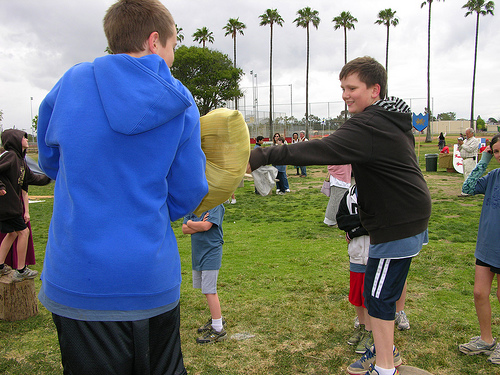

True Caption: Two people stand on a beach and look to the right .
Generated Caption: people are walking on the beach. one is pointing at the other's face. the two are standing on the sand. the man is pointing. the woman is standing in the distance. the person in the red jacket is pointing to the water. the other is standing on a rocky beach. the people are standing in shallow water. on the shore, the man in the blue jacket is walking. the girl in the pink jacket is standing. the couple in the foreground are standing. walking. in the sand, the woman in the brown jacket is looking at the object in the snow. the object is in the air.


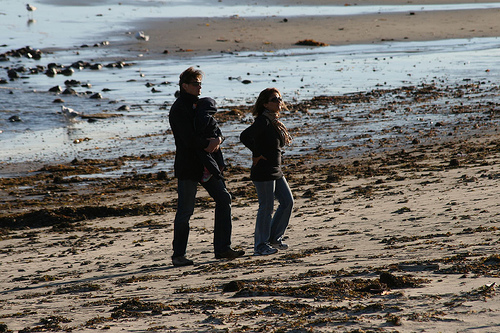

True Caption: A man with four running dogs in nature .
Generated Caption: man and a dog are standing in a grassy area with trees in the background. The man is wearing a white shirt and black shorts. The dog is standing in front of the man. The two dogs are wearing white shirts.. The woman is wearing black pants.. and the man is carrying a backpack. The three dogs are walking. The dogs are running.. the woman is standing with a man in a blue jacket. The four dogs are standing.. a man is standing next to a black and white dog with a white collar.. on a dirt path.. with a woman in the


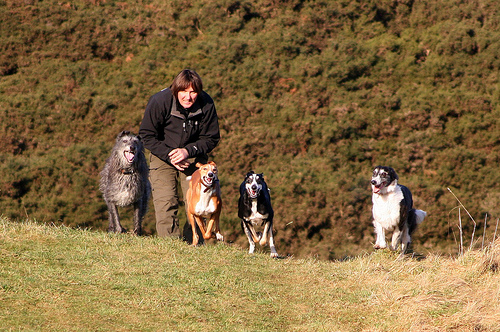

True Caption: An old woman is sitting in a cafe with a glass of water .
Generated Caption: woman sitting at a table in front of a white wall with a drink in her hand. She is looking at a book on the table. She has a black purse in her lap. She looks at her cellphone. She drinks at a restaurant. She sits at a bar. She does not speak. She reads a book. She eats at a place. She smokes a cigarette. She wears a black tank top. She leans against a table at a cafe. She appears to be in a room with a black shirt. She stares at a picture on a laptop. She smiles at a drink. She stands at a desk.


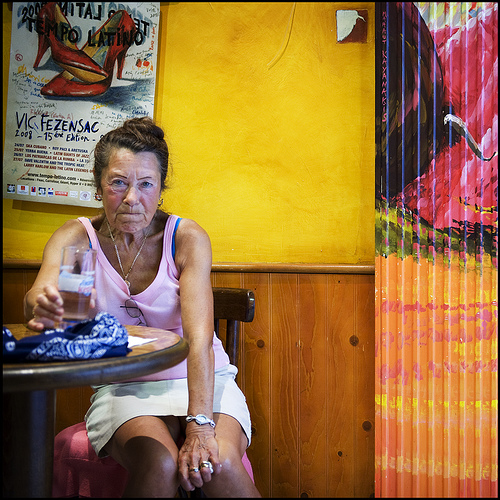

True Caption: Two dogs run towards shore through shallow water .
Generated Caption: black dog is running through the water with a stick in its mouth... a lake in the background.. another dog is in the foreground.. and a third dog is jumping out of the water.. in a lake.. the water is clear. the sky is blue. a ball is flying through the air. a body of water. the dog is swimming. the ball is coming out of its body. in the water, the dog catches the stick. the lake is blue and the dog has caught the ball. the two dogs are running towards the shore. the object is a ball in the lake.


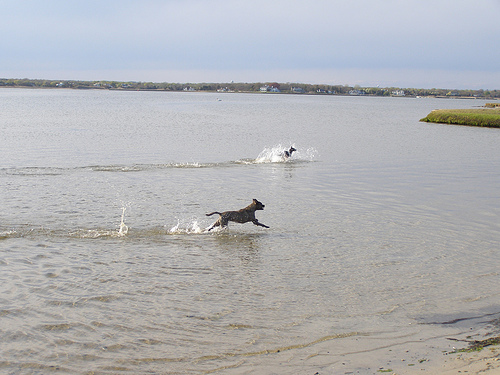

In [144]:
import matplotlib.pyplot as plt
for key in img_ids:
    img = Image.open("/kaggle/input/flickr8k/Images/" + test_df['image'][key]).convert("RGB")
    print(f'True Caption:', test_df['caption'][key])
    print(f'Generated Caption:', ' '.join(test_df['gen_captions'][key]))
    display(img)

In [78]:
smoothie = SmoothingFunction().method4
all_captions = []
for caption in test_df.caption:
    all_captions.append(caption.split())
all_predictions_new = []
for prediction in all_predictions:
    predictionNew = []
    for word in prediction:
        predictionNew.append(word)
        if '.' in word:
            break
    all_predictions_new.append(predictionNew)
all_captions[49], all_predictions_new[49]

In [100]:
corpus_bleu(all_captions, all_predictions_new)

0.5301507380266092

In [101]:
corpus_bleu(all_captions, all_predictions_new, weights = [1,0,0,0])

0.07899461400359067

In [108]:
corpus_bleu(all_captions, all_predictions_new, weights = [0.5,0.5,0,0])

0.2810598050301584

In [106]:
corpus_bleu(all_captions, all_predictions_new, weights = [0.3,0.3,0.3,0])

0.46695953130496265

In [107]:
corpus_bleu(all_captions, all_predictions_new, weights = [0.25,0.25,0.25,0.25])

0.5301507380266092

In [115]:
sumScore = 0
for i in range(50):
    sumScore += sentence_bleu(all_captions[i], all_predictions_new[i])
sumScore / 50

0.47015994071018474

# # **Sentiment analysis**

In [116]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import transformers
from transformers import BertTokenizer, BertModel
import torchvision.transforms as transforms

In [117]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch
# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [131]:
output = []
class_names = ['negative', 'positive']
true_sentiments = []

for j in range(50):
    x = all_captions[j]
    encoded_review = tokenizer.encode_plus(
      x,
      max_length=25,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    input_ids = encoded_review['input_ids']
    attention_mask = encoded_review['attention_mask']

    output = model(input_ids, attention_mask)
    logits = output.logits
    scores = torch.softmax(logits, dim=1)
    sentiment = scores.argmax().item()

#     print(f'Ground Truth:', ' '.join(x))
    print(f'Sentiment  : {class_names[sentiment]}')

    y = all_predictions[j]
    encoded_review = tokenizer.encode_plus(
      y,
      max_length=25,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    input_ids = encoded_review['input_ids']
    attention_mask = encoded_review['attention_mask']

    output = model(input_ids, attention_mask)
    logits = output.logits
    scores = torch.softmax(logits, dim=1)
    sentiment = scores.argmax().item()
#     print(sentiment)
#     print(f'Predicted: ', ' '.join(y))
    print(f'Sentiment  : {class_names[sentiment]}')
    print('-------')

Ground Truth: The boy in the black sweatshirt is hitting the yellow object held by the boy in the blue sweatshirt .
Sentiment  : positive
Predicted:  man and a woman are standing in front of a large group of people. One man is pointing at something while the other man looks at it. The man is holding a camera. The woman is standing next to the man... the man is looking at the camera.. and the woman is looking away.. at the man's hand.. a man in a black shirt is standing behind the man in the white shirt.. another man is standing in the foreground.. two people are standing behind a man., while a third man stands in the background.. in a crowd, a man is throwing
Sentiment  : positive
-------
Ground Truth: Two people stand on a beach and look to the right .
Sentiment  : positive
Predicted:  people are walking on the beach. one is pointing at the other's face. the two are standing on the sand. the man is pointing. the woman is standing in the distance. the person in the red jacket is pointi